### See if power spectral density is a good way to check unit drift

In [45]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from scipy.ndimage import gaussian_filter1d

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy.signal import welch
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
tqdm.pandas()

subject = "SA"

args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500

args.subject = subject

In [47]:
def load_session_beh(row, subject):
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, row.session_name)
    beh["session"] = int(row.session_name)
    return beh

def get_all_beh(subject):
    valid_sessions = pd.read_pickle(SESSIONS_PATH.format(sub=subject))
    all_beh = pd.concat(valid_sessions.apply(lambda x: load_session_beh(x, subject), axis=1).values)
    return all_beh

In [48]:
all_beh = get_all_beh(subject)

In [49]:
def compute_avg_frs(unit_id, all_beh):
    session = unit_id // 100
    all_frs = []
    beh = all_beh[all_beh.session == session]
    for event_idx, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
        args.trial_event = event
        args.trial_interval = get_trial_interval(event)
        frs = io_utils.get_frs_from_args(args, session)
        frs = frs[frs.TrialNumber.isin(beh.TrialNumber)]
        frs = frs[frs.PseudoUnitID == unit_id]
        all_frs.append(frs)
    all_frs = pd.concat(all_frs)
    avg_frs = all_frs.groupby(["TrialNumber"]).FiringRate.mean().reset_index(name="AvgFiringRate")
    return avg_frs


In [50]:
_, _, pref_res = io_utils.read_anova_res_all_time(args, "99th", "BeliefPref", read_shuffle=True)
n_timebins_sig = pref_res.groupby(["PseudoUnitID", "feat", "structure_level2"]).abs_time.nunique().reset_index(name="n_timebins")

In [51]:
n_timebins_sig = n_timebins_sig.groupby("PseudoUnitID").n_timebins.max().reset_index(name="n_timebins").sort_values(by="n_timebins", ascending=False)
# n_timebins_sig = n_timebins_sig[:200]

In [52]:
fs = 1  

def get_psd(row, all_beh):
    avg_frs = compute_avg_frs(row.PseudoUnitID, all_beh)
    frequencies, psd = welch(avg_frs['AvgFiringRate'], fs=fs)
    psd_norm = psd / np.sum(psd)
    mean = np.dot(psd_norm, frequencies) / len(psd_norm)

    low_freq_idxs = np.nonzero(frequencies < 0.01)
    low_freq_dens = np.sum(psd_norm[low_freq_idxs])
    return pd.Series({"psd": psd_norm, "frequencies": frequencies, "mean": mean, "low_freq_dens": low_freq_dens})


n_timebins_sig[["psd", "frequencies", "mean", "low_freq_dens"]] = n_timebins_sig.progress_apply(lambda x: get_psd(x, all_beh), axis=1)
n_timebins_sig = n_timebins_sig.sort_values(by="low_freq_dens", ascending=False)

  0%|          | 0/935 [00:00<?, ?it/s]

100%|██████████| 935/935 [01:18<00:00, 11.93it/s]


<Axes: >

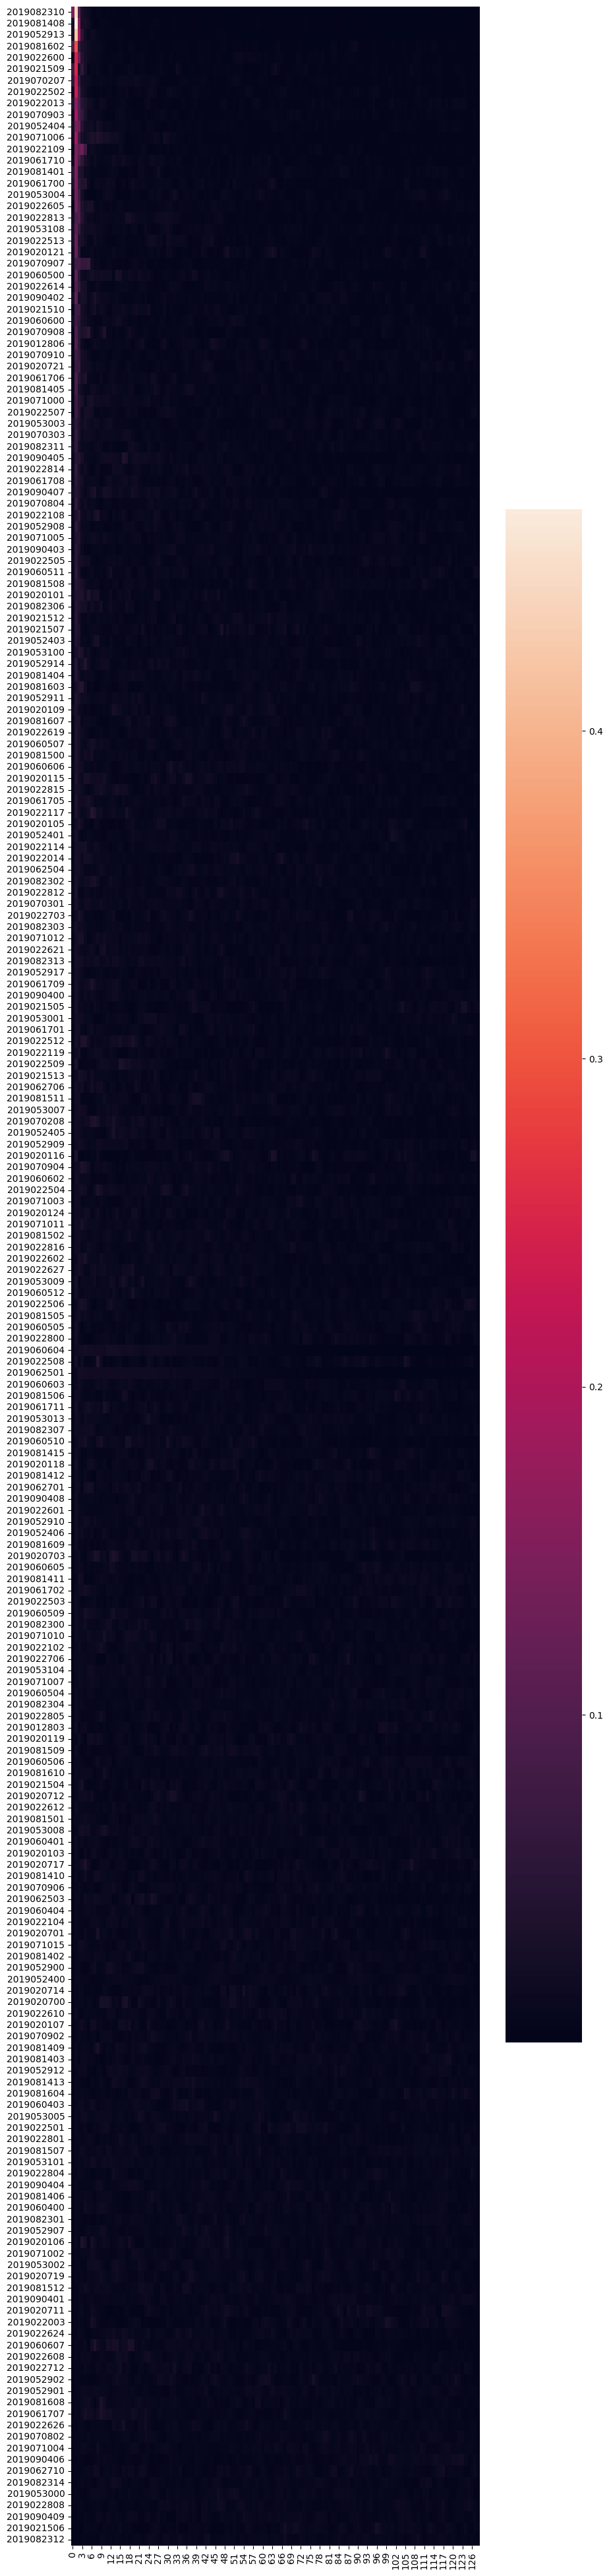

In [41]:
# data_matrix = np.vstack(filt_sig.psd.values)
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(data_matrix, yticklabels=filt_sig.PseudoUnitID, ax=ax)

data_matrix = np.vstack(n_timebins_sig.psd.values)
fig, ax = plt.subplots(figsize=(10, 50))
sns.heatmap(data_matrix, yticklabels=n_timebins_sig.PseudoUnitID, ax=ax)

### Spot check a few

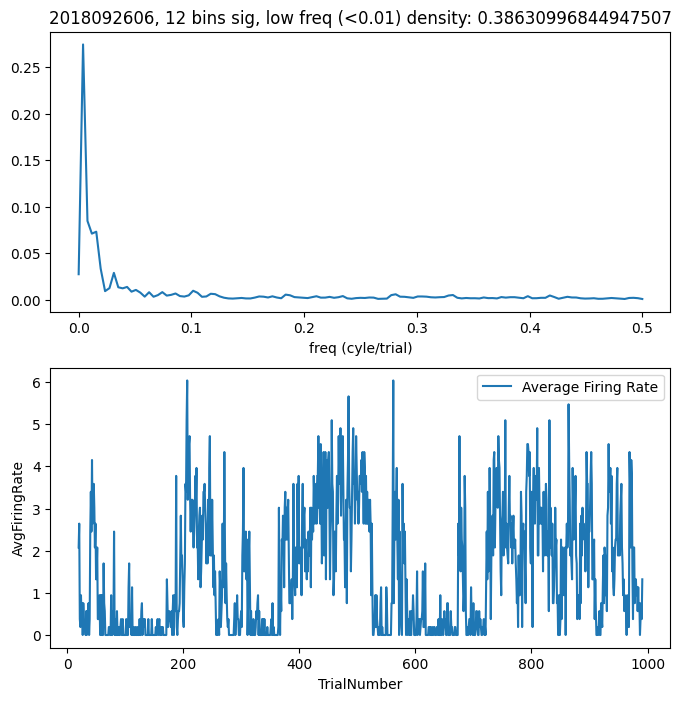

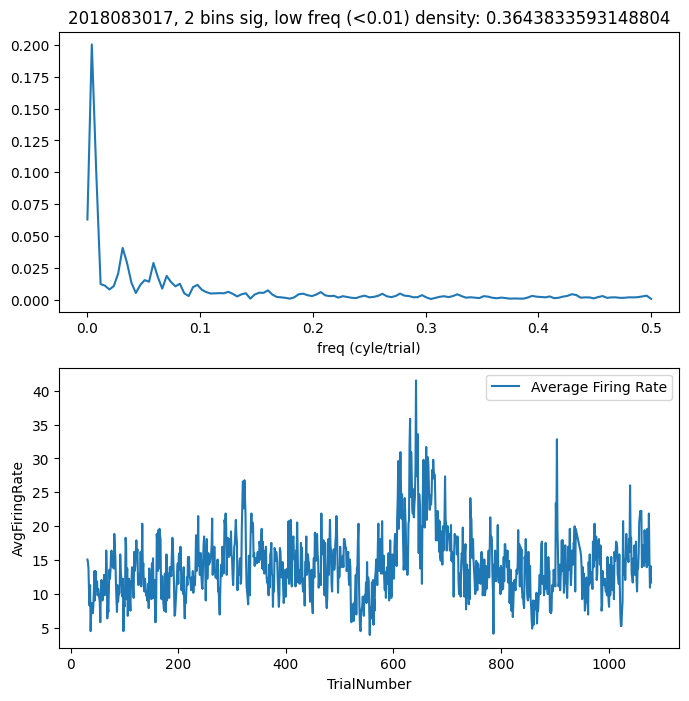

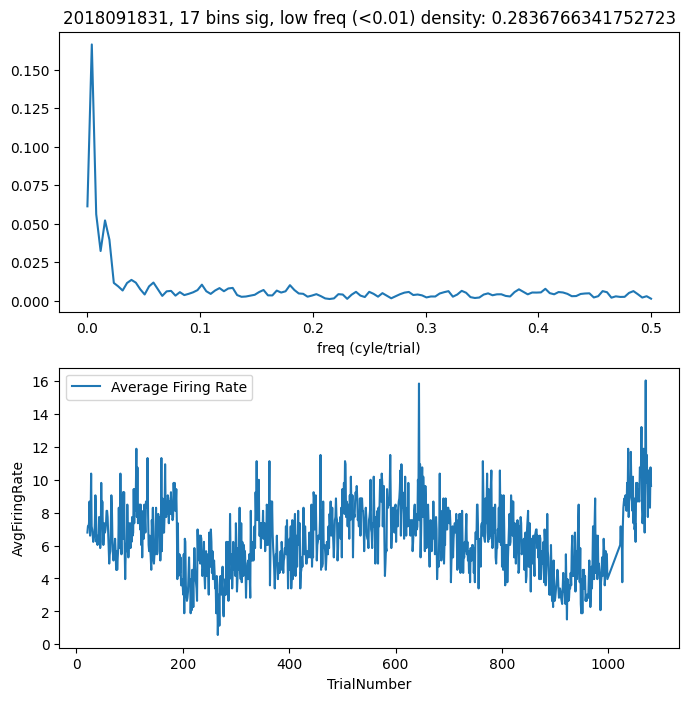

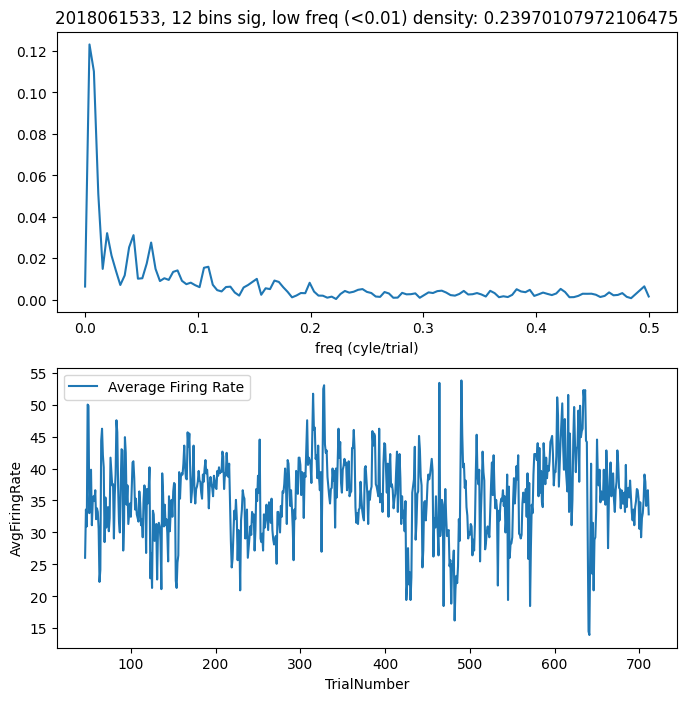

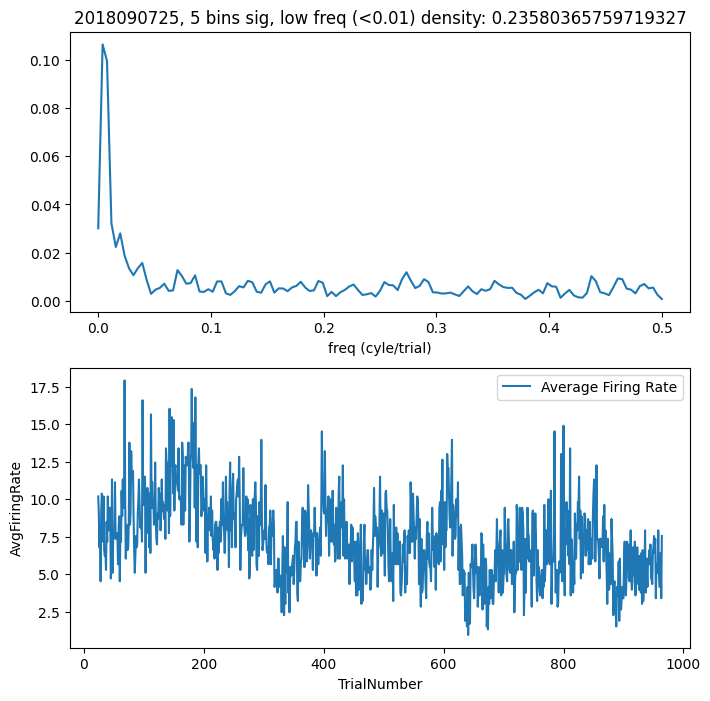

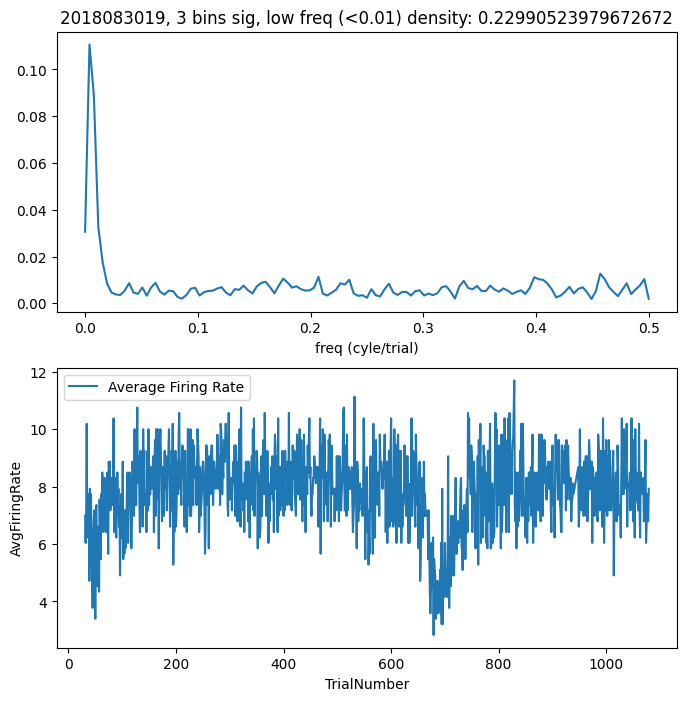

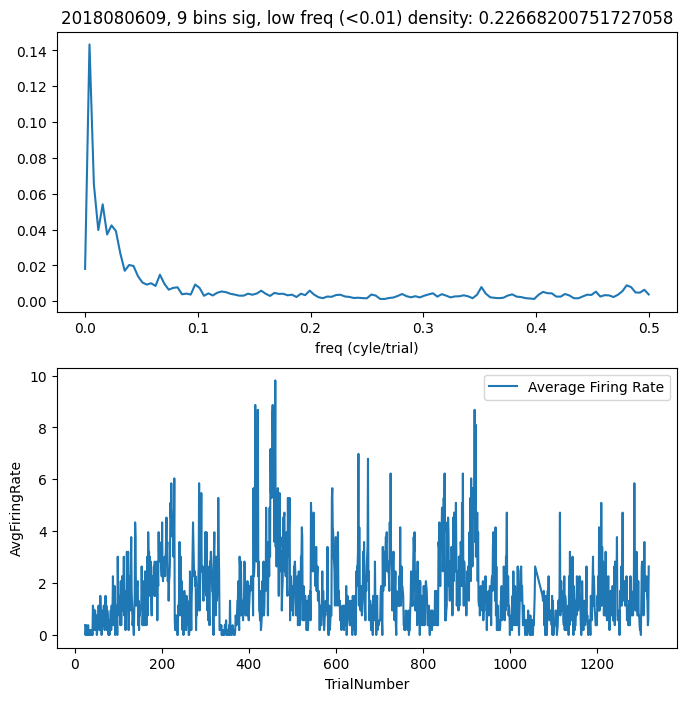

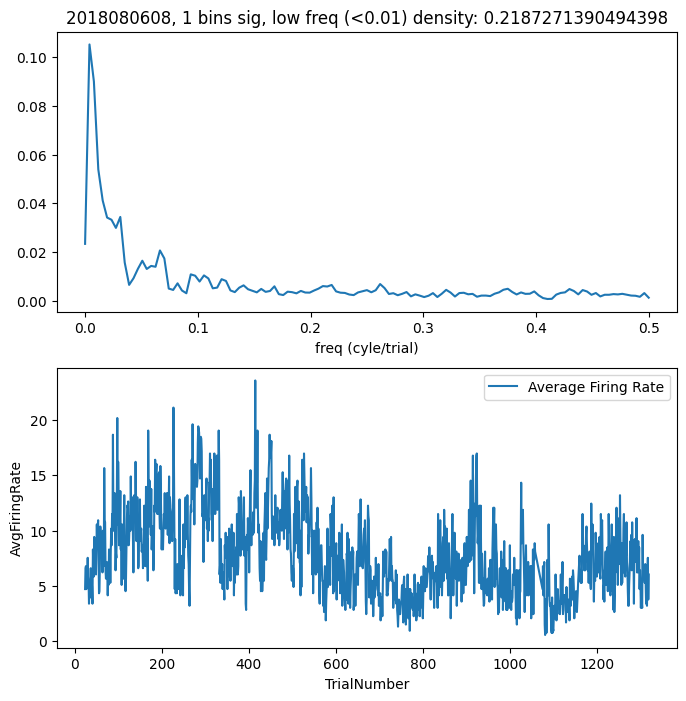

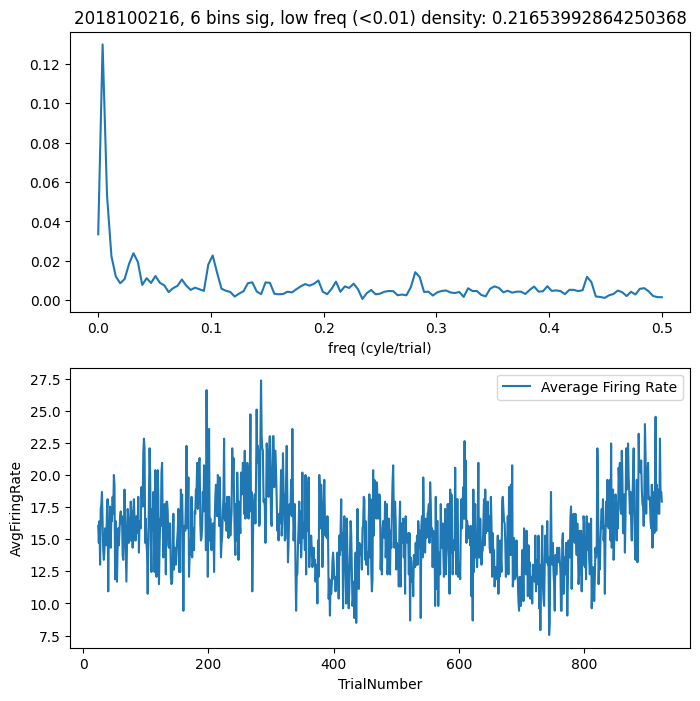

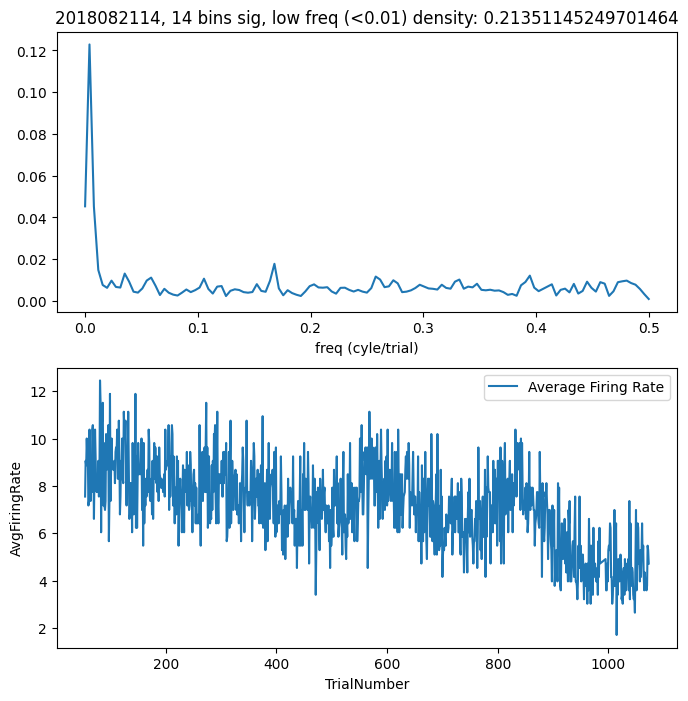

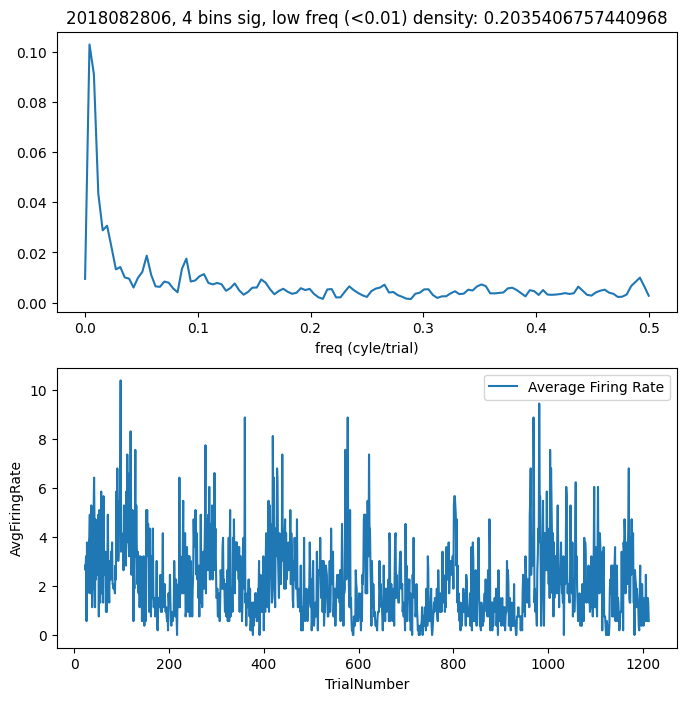

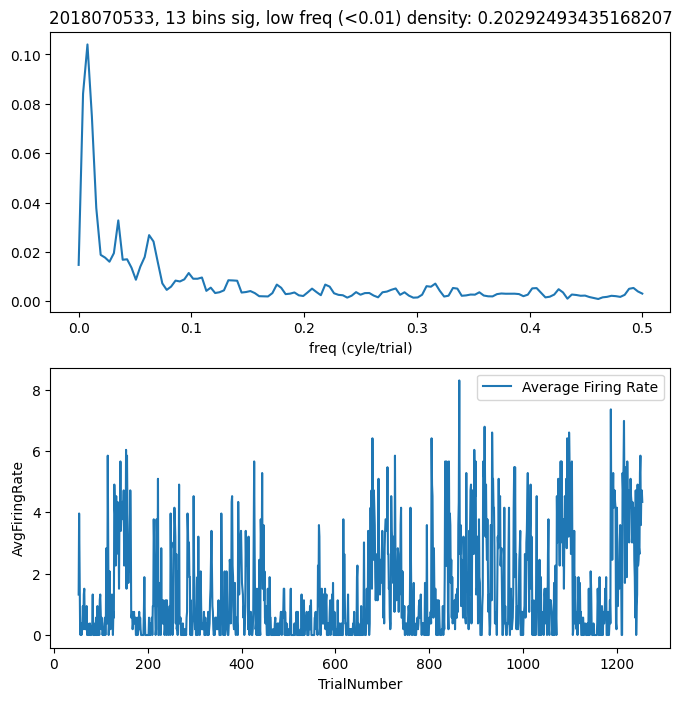

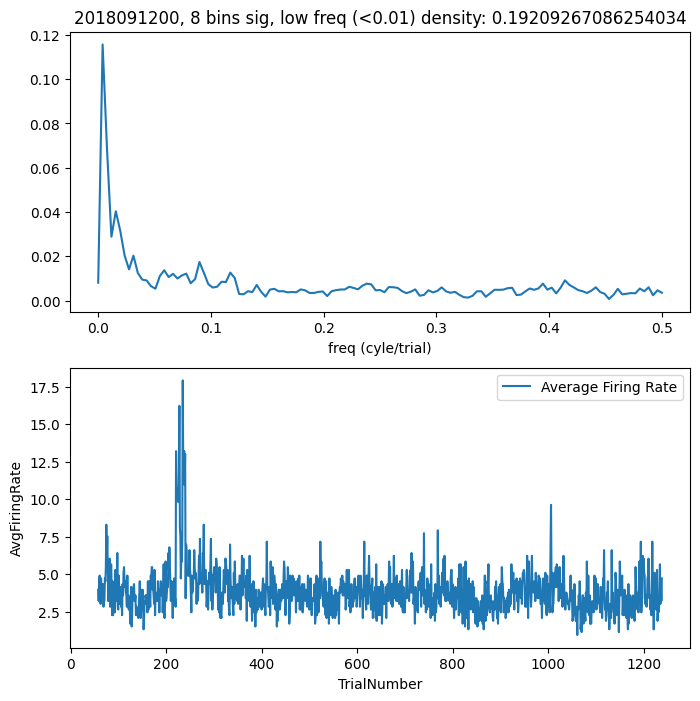

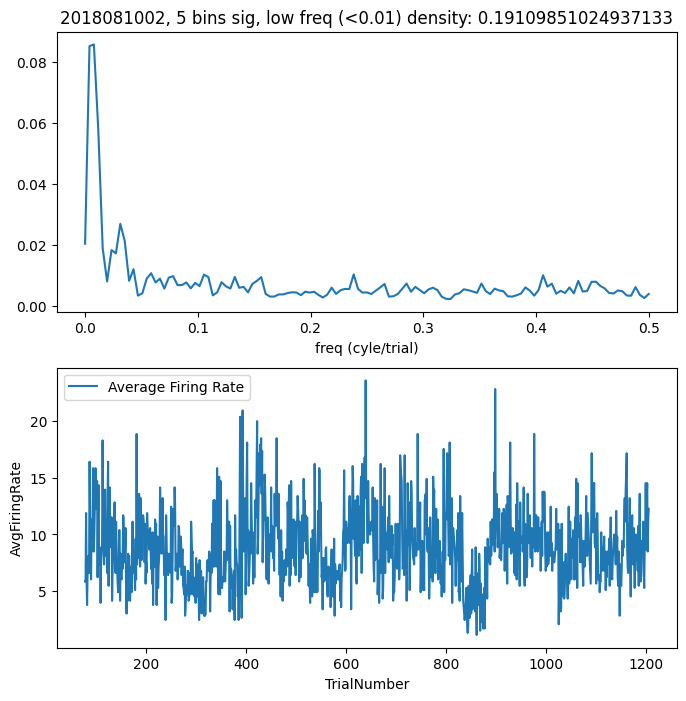

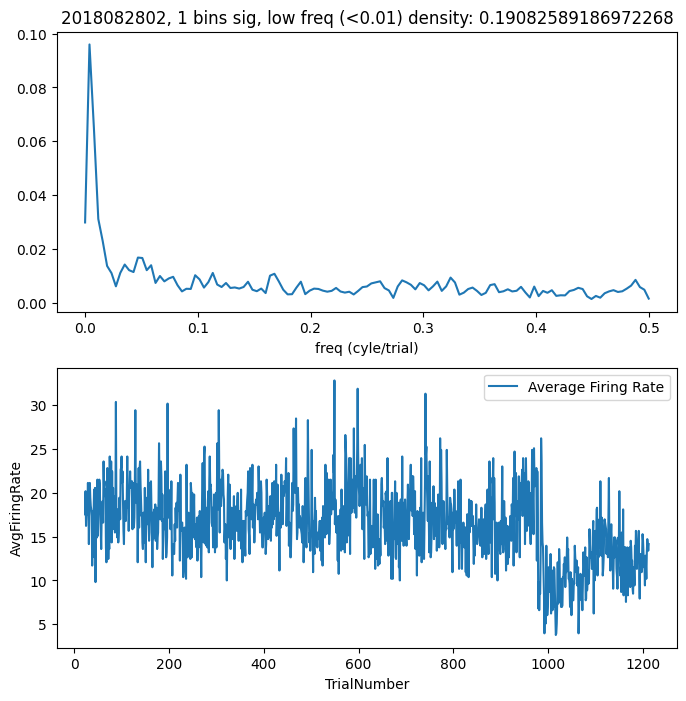

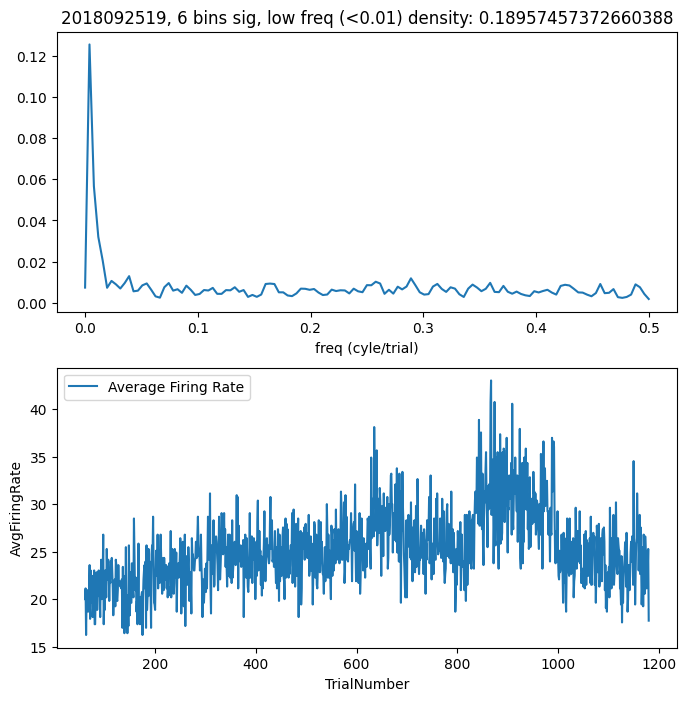

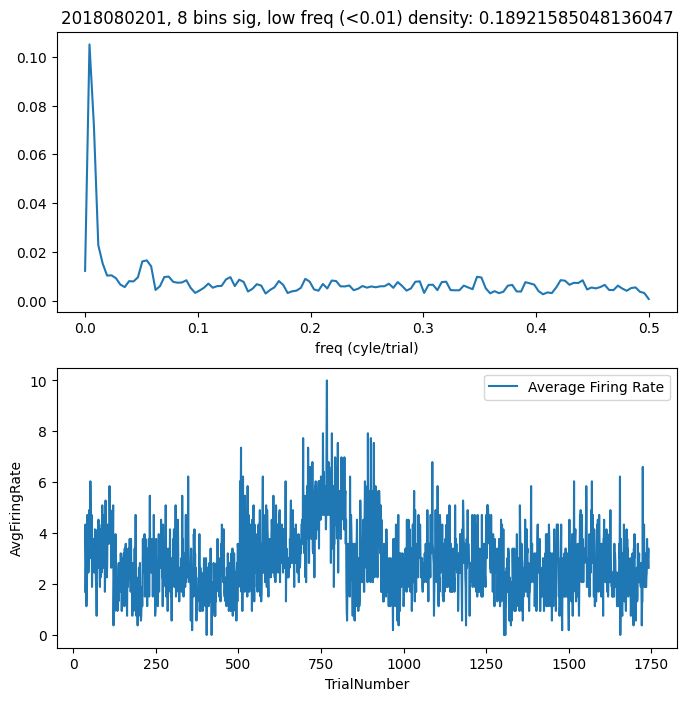

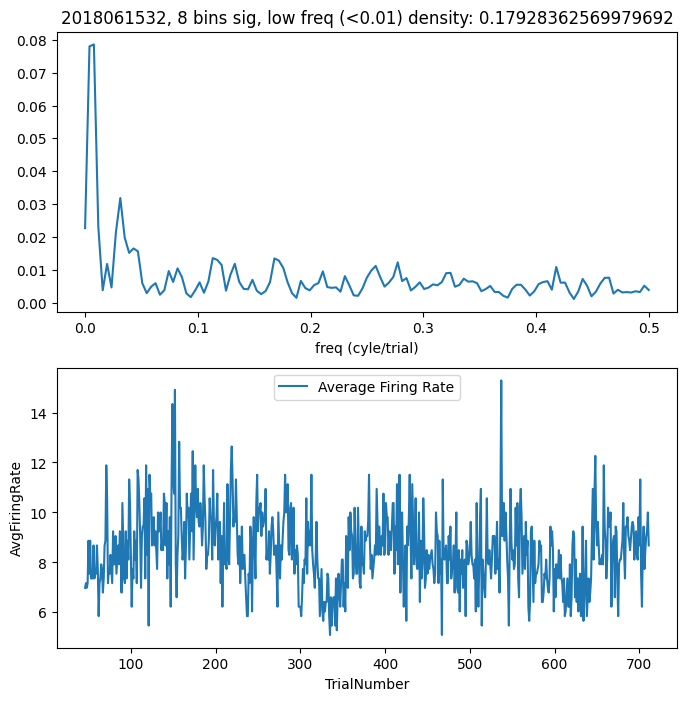

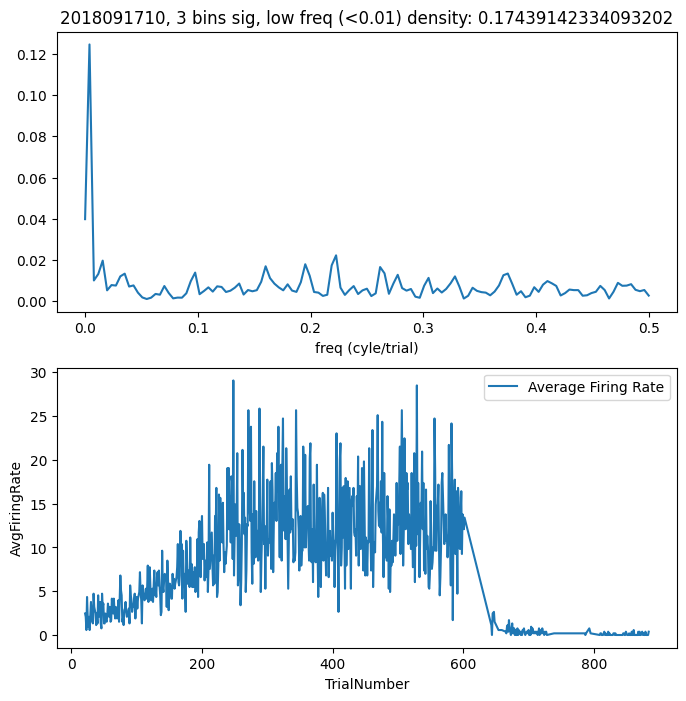

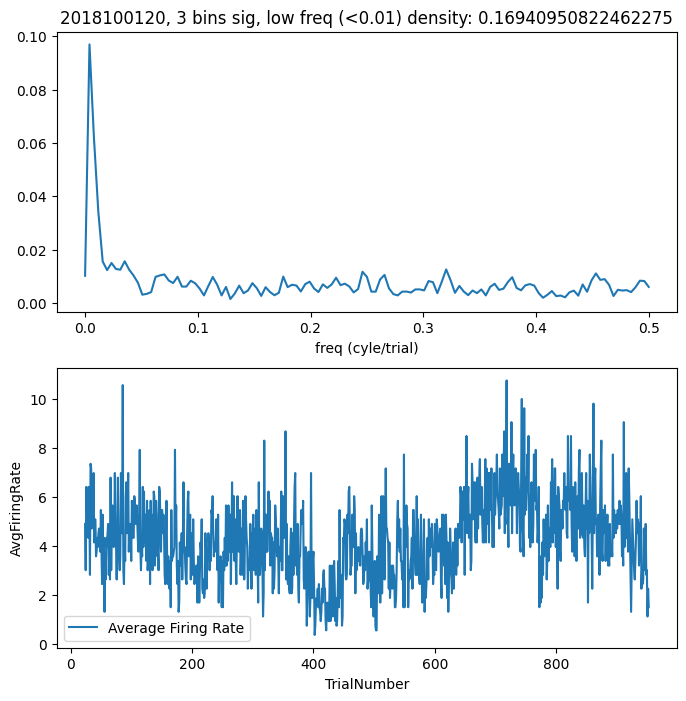

In [53]:
for i, row in n_timebins_sig[:20].iterrows():
    avg_fr = compute_avg_frs(row.PseudoUnitID, all_beh)
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].plot(row.frequencies,  row.psd)
    axs[0].set_xlabel("freq (cyle/trial)")
    axs[0].set_title(f"{row.PseudoUnitID}, {row.n_timebins} bins sig, low freq (<0.01) density: {row.low_freq_dens}")
    ax.set_ylabel("Density")
    sns.lineplot(avg_fr, x="TrialNumber", y="AvgFiringRate", label="Average Firing Rate", ax=axs[1])

### Look at few "good" ones

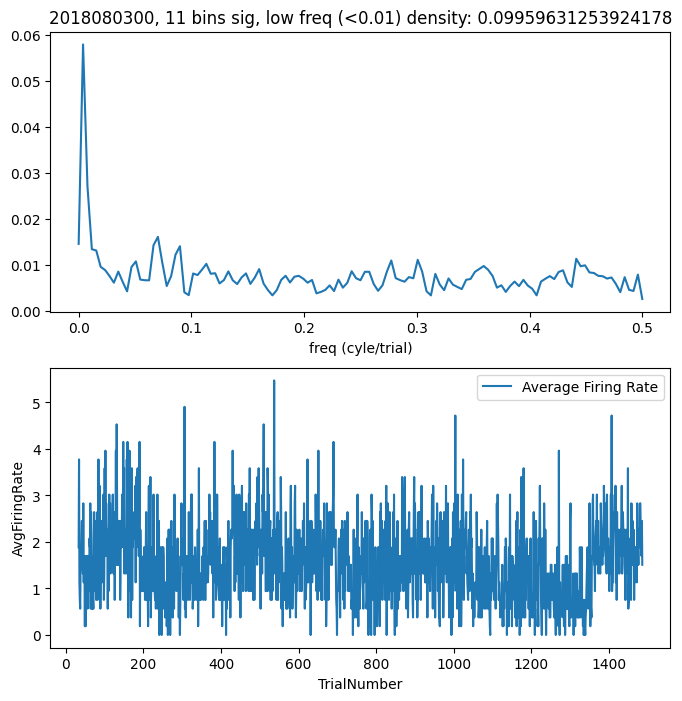

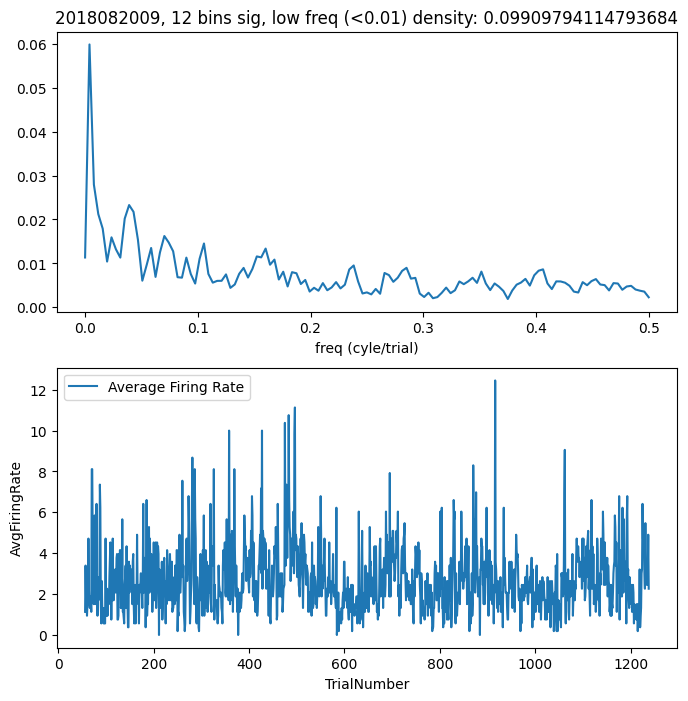

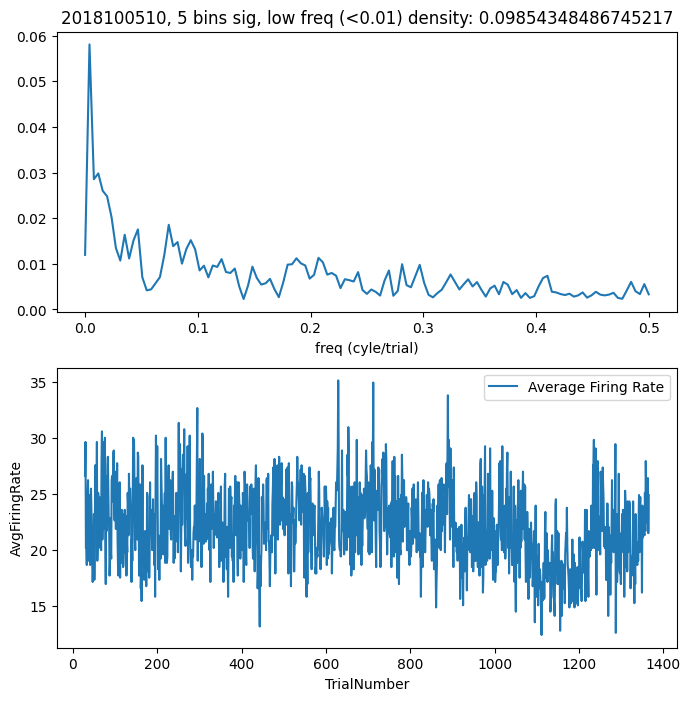

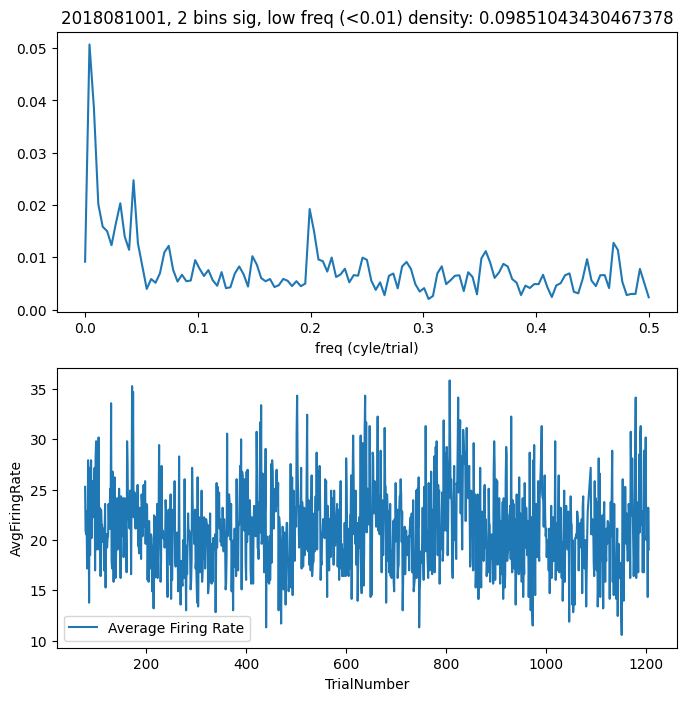

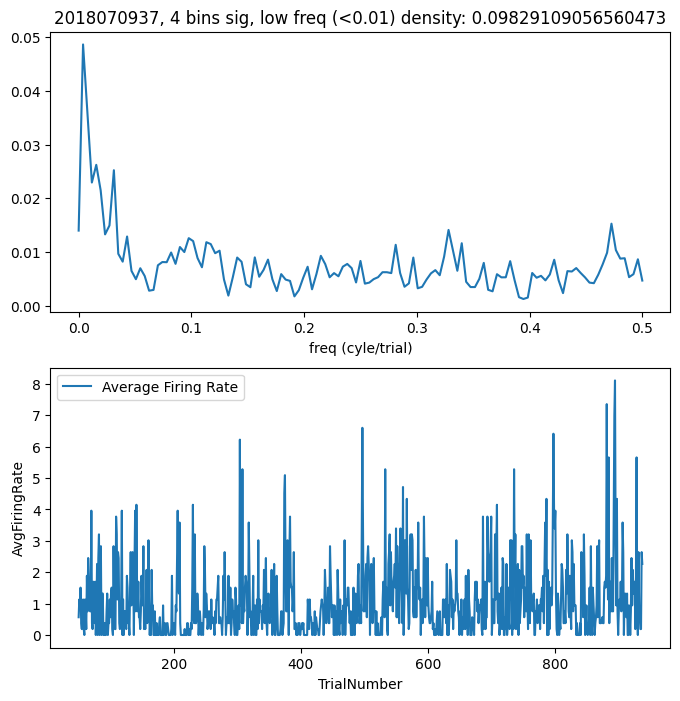

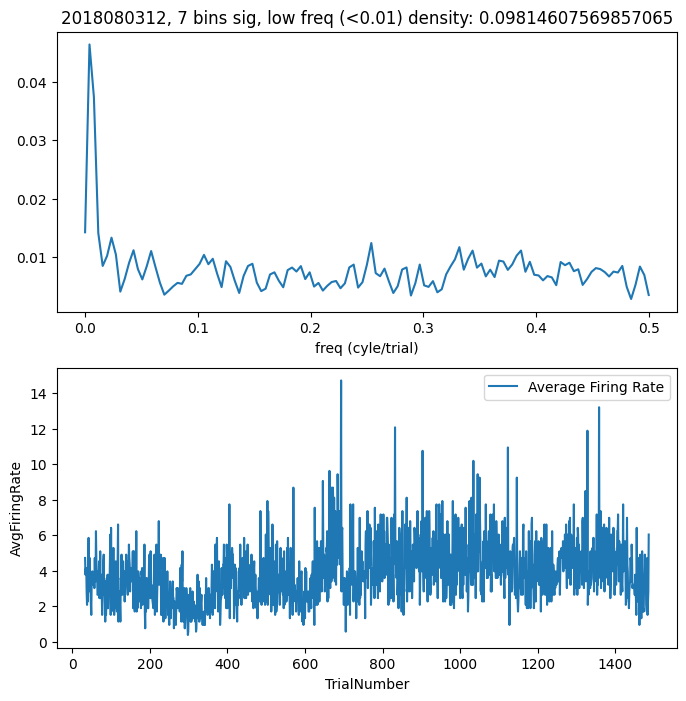

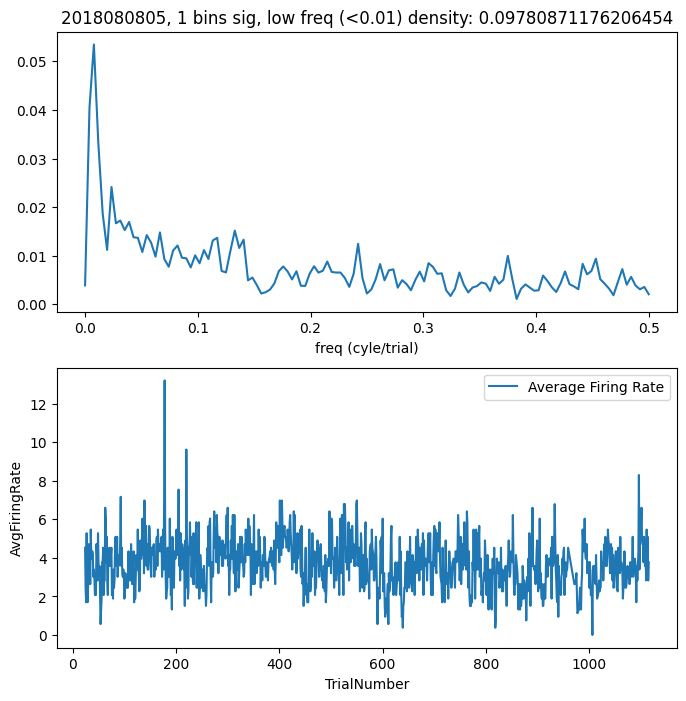

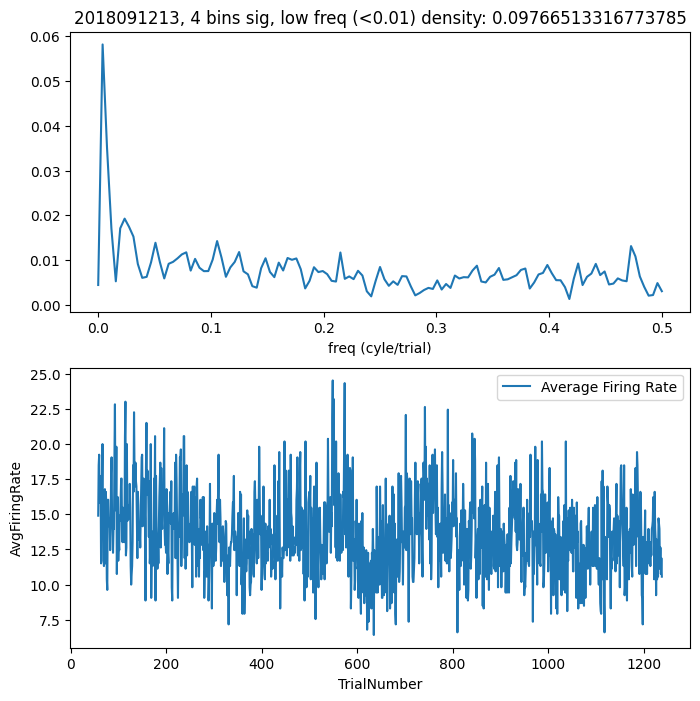

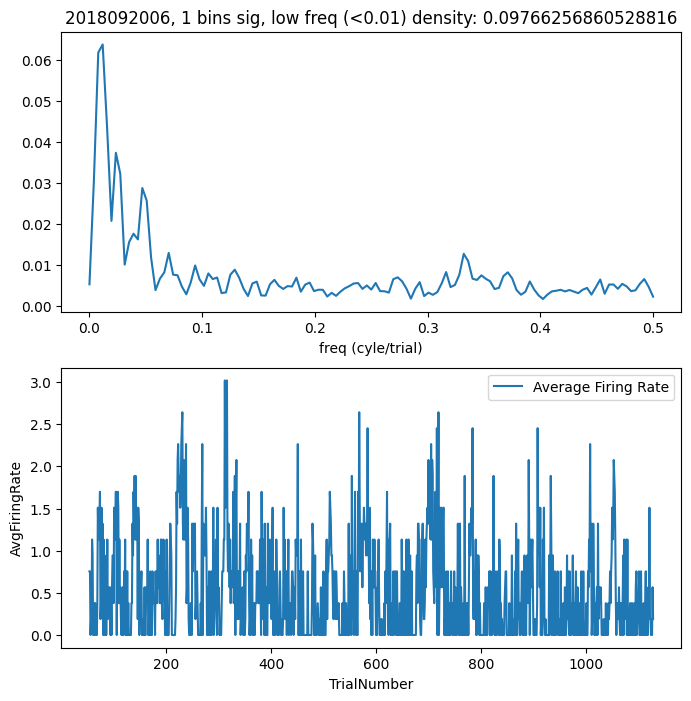

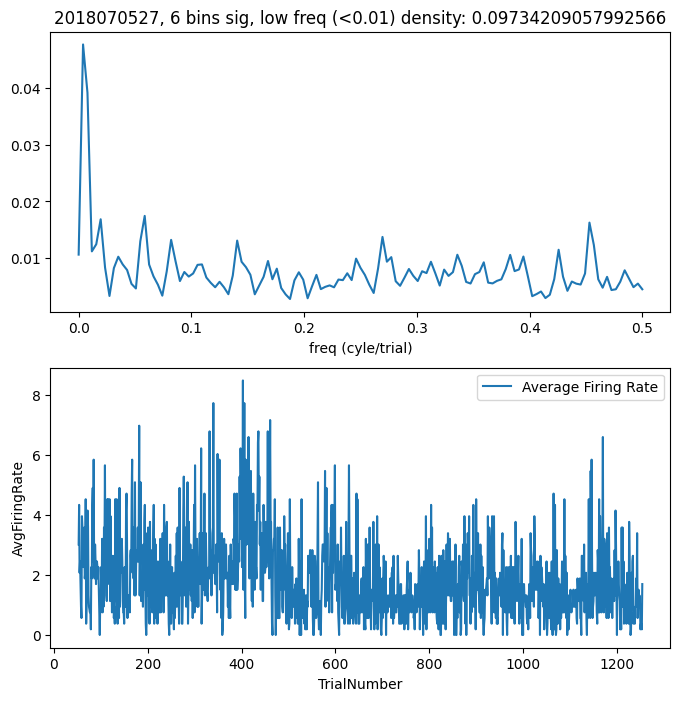

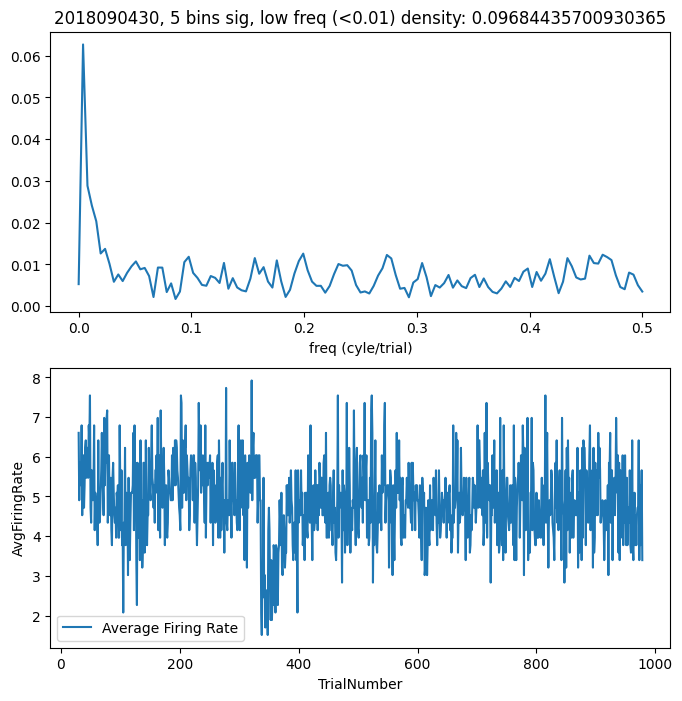

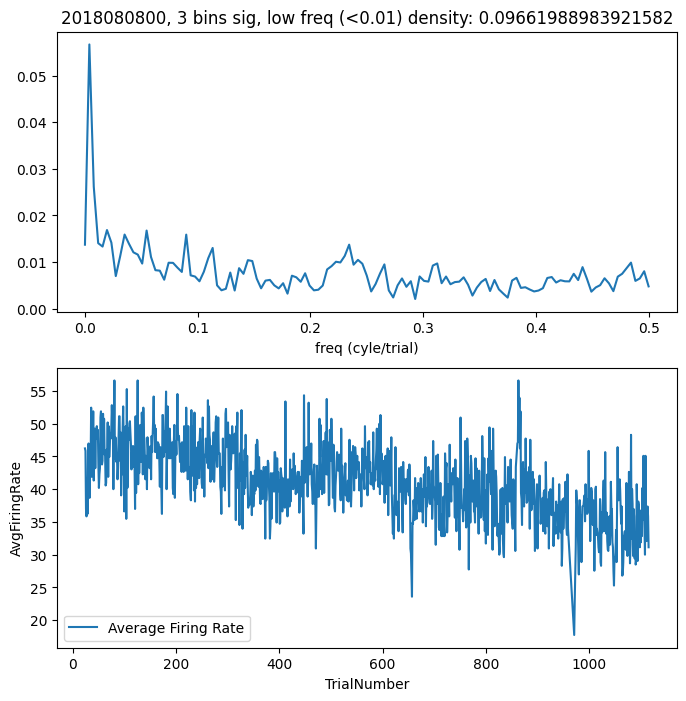

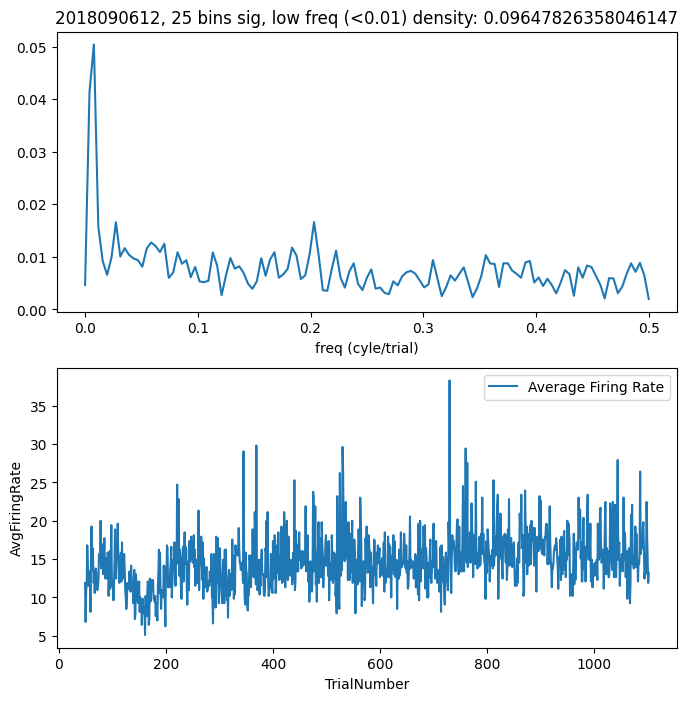

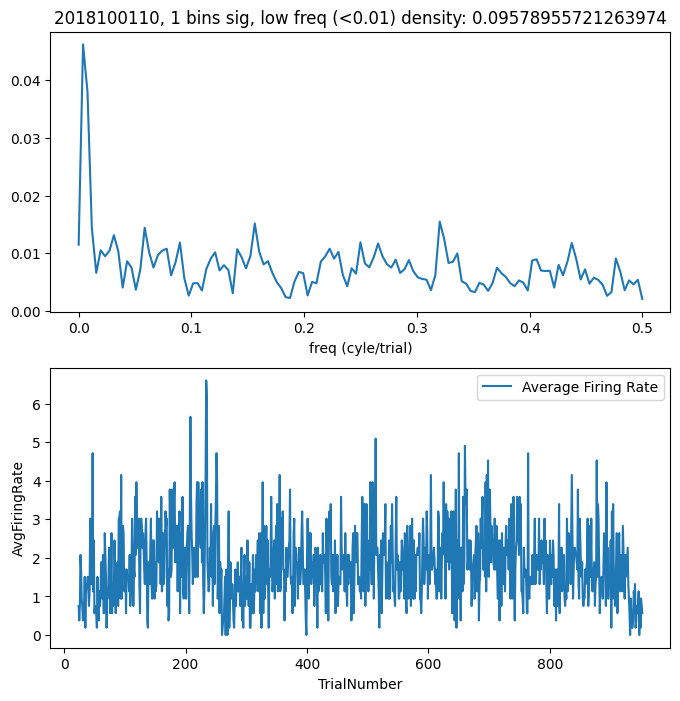

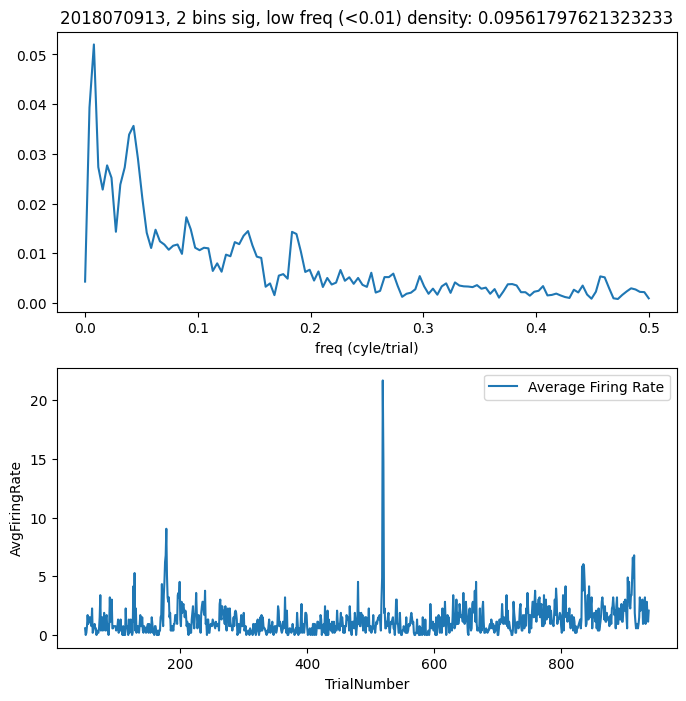

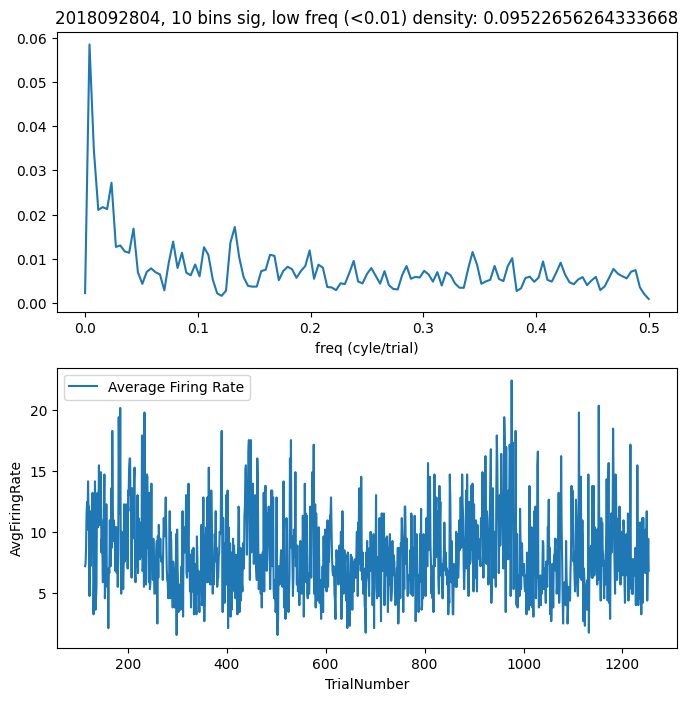

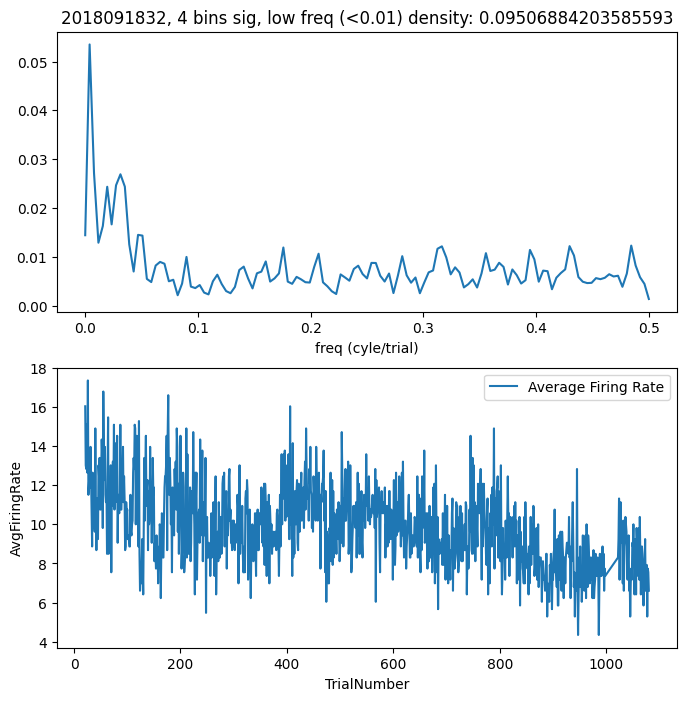

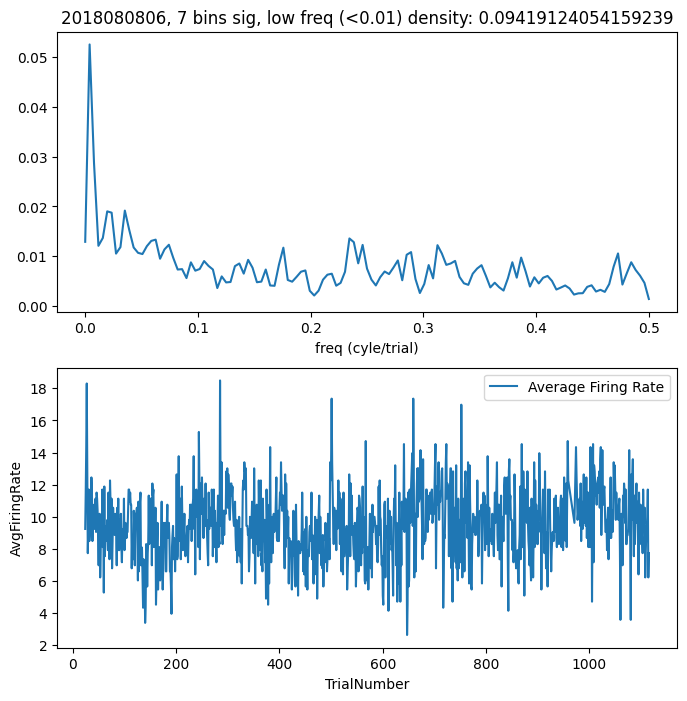

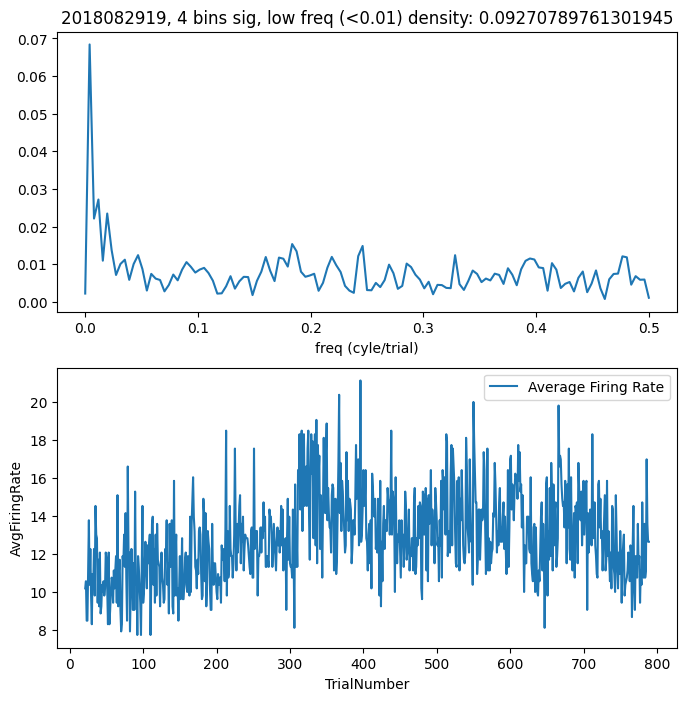

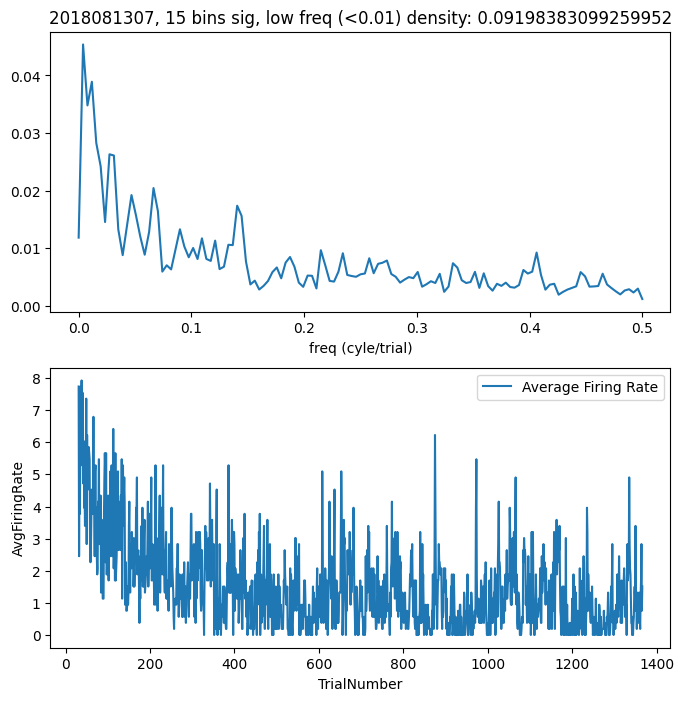

In [54]:
good_ones = n_timebins_sig[n_timebins_sig.low_freq_dens < 0.1]
for i, row in good_ones[:20].iterrows():
    avg_fr = compute_avg_frs(row.PseudoUnitID, all_beh)
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].plot(row.frequencies,  row.psd)
    axs[0].set_xlabel("freq (cyle/trial)")
    axs[0].set_title(f"{row.PseudoUnitID}, {row.n_timebins} bins sig, low freq (<0.01) density: {row.low_freq_dens}")
    sns.lineplot(avg_fr, x="TrialNumber", y="AvgFiringRate", label="Average Firing Rate", ax=axs[1])

In [55]:
len(n_timebins_sig[n_timebins_sig.low_freq_dens < 0.1]) / len(n_timebins_sig)

0.9176470588235294

### How many are being filtered out?